In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.style.use('fivethirtyeight')

In [3]:
import pandas as pd
import statsmodels.api as sm
import matplotlib

In [4]:
desminado  = pd.read_csv('SituacionDesminadoHumanitario.csv')
educacion  = pd.read_csv('EducacionRiesgoMinas.csv')
casos      = pd.read_csv('EventosMinas.csv')
victimas   = pd.read_csv('VictimasMinas.csv')
municipios = pd.read_csv('MunicipiosDANE.csv')

In [5]:
educacion["FECHA_FINALIZACION"] = pd.to_datetime(educacion["FECHA_FINALIZACION"])
educacion["FECHA_INICIO"] = pd.to_datetime(educacion["FECHA_INICIO"], format="%m/%d/%Y %I:%M:%S %p", infer_datetime_format=False)   # 11/13/2019 12:00:00 AM    "%m/%d/%Y %I:%M:%S %p"
educacion["DURACION"] = educacion["FECHA_FINALIZACION"] - educacion["FECHA_INICIO"]
educacion["DURACION"] = educacion["DURACION"].apply(lambda x: x.days+1)
educacion = educacion[educacion["DURACION"] == 1]

In [6]:
victimas = victimas.rename(columns={"ano":"AÑO","mes":"MES","codigodanemunicipio":"CODIGO_DANE_MUNICIPIO"})

In [7]:
# date: month,year
def filterData(df, mun_dane_code=None, date=(None,None)):
  victimas = df
  month, year = date
  if month != None and year != None:
    victimas = victimas[(victimas["AÑO"]==year) & (victimas["MES"]==month)]
  if mun_dane_code != None:
    victimas = victimas[victimas["CODIGO_DANE_MUNICIPIO"] == mun_dane_code]
  return victimas

In [8]:
def getDate(month,year):
    if month < 10:
        fecha = '01/0' + str(month) + '/' + str(year)
    else:
        fecha = '01/' + str(month) + '/' + str(year)
    return fecha

In [9]:
def getDateAux(date):
    month,year = date
    return getDate(month,year)

In [10]:
def getTimeSeries(df,mun_dane_code, considerZero):
    for year in range(1990,2020):
        for month in range(1,12+1):
            fecha = getDate(month,year)
            casos_filtered = filterData(casos,mun_dane_code,date=(month,year))
            nCasos = len(casos_filtered)
            row = { 'fecha':fecha,
                    'casos':nCasos,
                    #'municipio':mun_dane_code
                  }
            if (nCasos > 0) or (considerZero):
                df = df.append(row, ignore_index=True)
    return df

In [11]:
def getData(municipio, considerZero=True, setPeriod=True):
    df = pd.DataFrame({'casos': pd.Series([], dtype='int'),
                       'fecha': pd.Series([], dtype='string')})
    timeSeries = pd.DataFrame(columns=['fecha','casos'])
    timeSeries = getTimeSeries(timeSeries,municipio, considerZero)
    timeSeries['fecha'] = pd.to_datetime(timeSeries['fecha'], format='%d/%m/%Y')
    timeSeries['casos'] = pd.to_numeric(timeSeries['casos'])
    timeSeries = timeSeries.set_index('fecha')
    if setPeriod:
        timeSeries.index = timeSeries.index.to_period('M')
    return timeSeries

In [12]:
#municipio = 52835  # Tumaco
municipio = 50711  # Vista Hermosa - Meta
#municipio = 50251   # El castillo - Meta

timeSeries = getData(municipio, considerZero=True)

## Visualización de la Serie de Tiempo

<AxesSubplot:xlabel='fecha'>

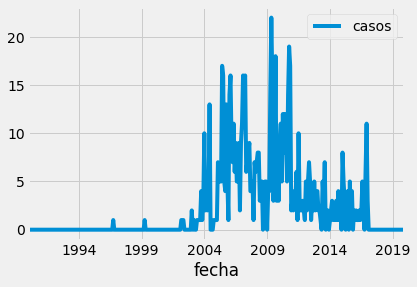

In [13]:
timeSeries.plot()

## Verificar que la Serie no sea Estacionaria

Utilizando el test de __Augmented Dickey Fuller__, se valida a traves de una prueba de hipótesis nula que la serie de tiempo no sea Estacionaria.

In [14]:
from statsmodels.tsa.stattools import adfuller

In [15]:
def adf_test(series,debug=False):
    results = adfuller(series)
    adf, p_value, lags, observations,_,_ = results
    print('\t*****   Resultados del test ADF   *****')
    tol = 0.05
    if p_value <= tol:
        print('Hay evidencia suficiente en contra de la hipótesis nula')
        print('Se rechaza la hipótesis nula')
        print('La Serie de Tiempo es Estacionaria')
    else:
        print('No hay suficiente evidencia en contra de la hipótesis nula')
        print('La serie de Tiempo NO es Estacionaria')
        
    if debug:
        print()
        print('ADF Test: ',adf)
        print('p-value:  ',p_value)
        print('N° Lags:  ',lags)
        print('N° Observations:',observations)

In [16]:
adf_test(timeSeries, debug=True)

	*****   Resultados del test ADF   *****
No hay suficiente evidencia en contra de la hipótesis nula
La serie de Tiempo NO es Estacionaria

ADF Test:  -1.6718158451879777
p-value:   0.44568915659036346
N° Lags:   13
N° Observations: 346


## Análisis de Autocorrelación

In [17]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

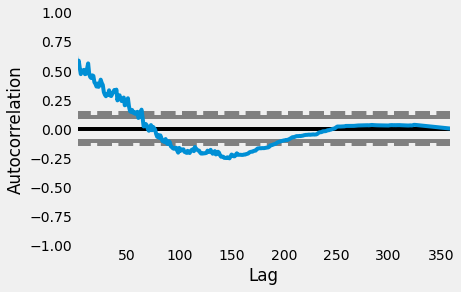

In [18]:
autocorrelation_plot(timeSeries)

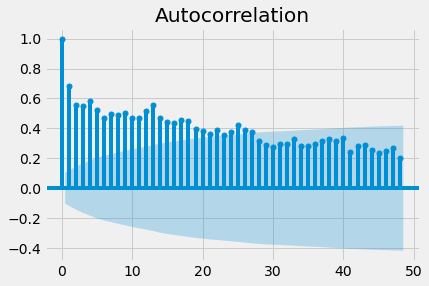

In [19]:
_ = sm.graphics.tsa.plot_acf(timeSeries,lags=12*4)

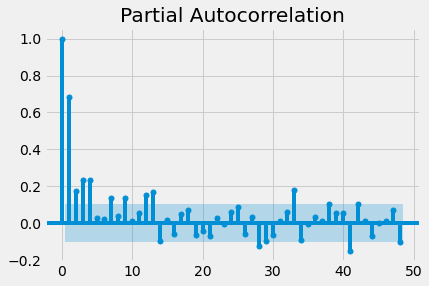

In [20]:
_ = sm.graphics.tsa.plot_pacf(timeSeries,lags=12*4)

# 2. Modelo Autoregresivo Integrado de Media Móvil (ARIMA)

In [21]:
import itertools

In [22]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [23]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [24]:
def findOptimalParameters(p_range, d_range, q_range):
    pdq_values = list(itertools.product(p_range, d_range, q_range))
    orders = []
    min_aic = 10**5
    optimalParams = None
    for order in pdq_values:
        mod = ARIMA(timeSeries,order=order)
        results = mod.fit()
        aic = results.aic
        if aic < min_aic:
            min_aic = aic
            optimalParams = order
            print(order,'\t',aic)
        orders.append((order,aic))
        if order[2] == 1:
            print('\t\t',order)
    return orders

In [25]:
p_r = range(1,6)
d_r = range(1,2)
q_r = range(1,10)
orders = findOptimalParameters(p_r, d_r, q_r)
#orders

(1, 1, 1) 	 1743.9971359952817
		 (1, 1, 1)
(1, 1, 5) 	 1743.9032258716434
(1, 1, 6) 	 1739.179249612561
		 (2, 1, 1)
(2, 1, 4) 	 1731.8265337874127
		 (3, 1, 1)
(3, 1, 3) 	 1731.4289045051864
		 (4, 1, 1)


/home/afzp99/miniconda3/envs/jupyter/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/afzp99/miniconda3/envs/jupyter/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


		 (5, 1, 1)


In [26]:
for order,aic in orders:
    if (aic < 1735):
        print(order,aic)

(2, 1, 4) 1731.8265337874127
(3, 1, 3) 1731.4289045051864
(3, 1, 4) 1733.5661693907455
(4, 1, 3) 1734.934320378516


### Create ARIMA model with Optimal Parameters

In [27]:
order = p,d,q = 3,1,3
model = ARIMA(timeSeries, order=(p,d,q))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  casos   No. Observations:                  360
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -858.714
Date:                Wed, 02 Dec 2020   AIC                           1731.429
Time:                        07:58:07   BIC                           1758.612
Sample:                    01-31-1990   HQIC                          1742.239
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7148      0.039    -18.509      0.000      -0.790      -0.639
ar.L2         -0.7027      0.041    -17.224      0.000      -0.783      -0.623
ar.L3          0.2146      0.039      5.451      0.000       0.137       0.292
ma.L1          0.1734      0.027      6.488      0.000       0.121       0.226
ma.L2          0.0858      0.030      2.857      0.004       0.027       0.145
ma.L3         -0.8672      0.031    -28.024      0.000      -0.928      -0.807
sigma2         6.9075      0.262     26.348      0.000       6.394       7.421
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               765.61
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):             310.99   Skew:                             1.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
#prediction = results.get_forecast(steps=12,dynamic=True)
#prediction.predicted_mean.plot()

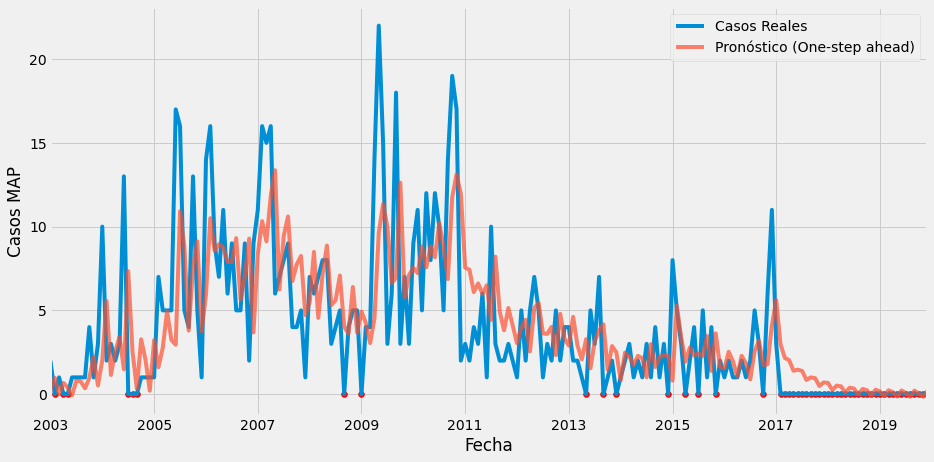

In [29]:
fechaInicio = '2003-01-01'
pred = results.get_prediction(start=pd.to_datetime(fechaInicio), dynamic=False)
casos_predecidos = pred.predicted_mean
casos_reales = timeSeries[fechaInicio:]['casos']
pred_ci = pred.conf_int()
ax = casos_reales.plot(label='Casos Reales')
points = casos_reales[casos_reales == 0]
plt.scatter(points.index, points.values, color='red')
pred.predicted_mean.plot(ax=ax, label='Pronóstico (One-step ahead)', alpha=.7, figsize=(14, 7))
#ax.fill_between(pred_ci.index,
#                pred_ci.iloc[:, 0],
#                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Fecha')
ax.set_ylabel('Casos MAP')
plt.legend()

### Diagnóstico del Modelo

In [30]:
mse = ((casos_predecidos - casos_reales) ** 2).mean()
print('MSE (Mean Squared Error)  {}'.format(round(mse, 2)))
print('Root MSE: {}'.format(round(np.sqrt(mse), 2)))

MSE (Mean Squared Error)  12.18
Root MSE: 3.49


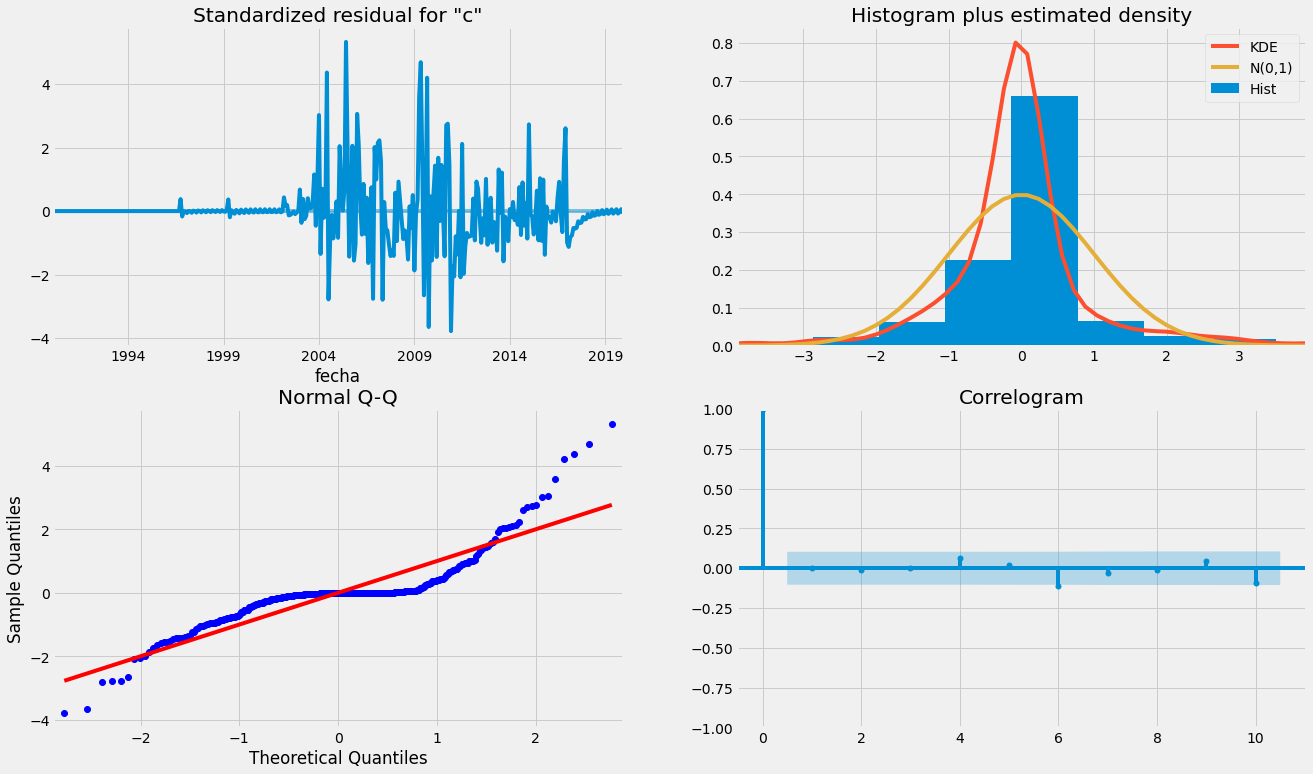

In [31]:
_ = results.plot_diagnostics(figsize=(20,12))

         residual
count  360.000000
mean     0.000429
std      2.633944
min     -9.960929
25%     -0.525864
50%      0.000000
75%      0.103985
max     14.054784


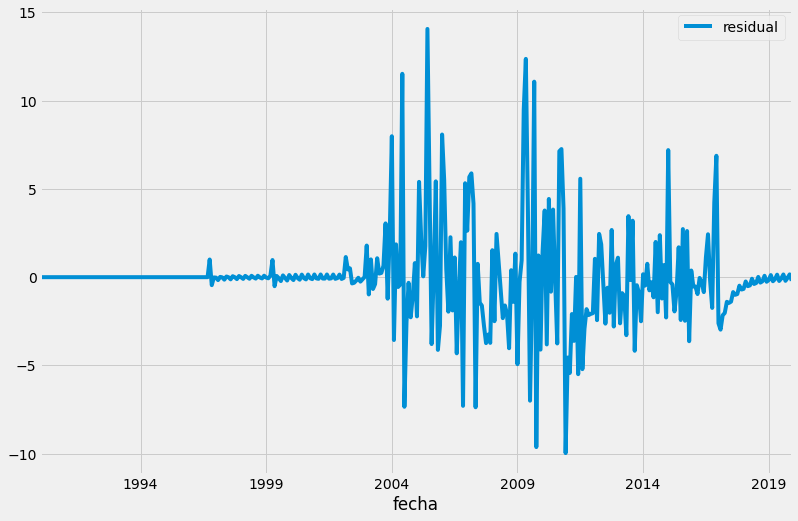

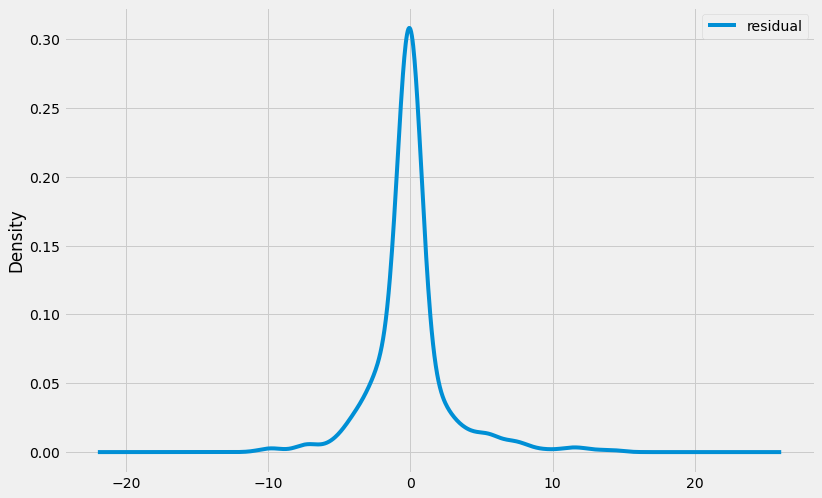

In [32]:
residuals = pd.DataFrame(results.resid)
residuals.rename(columns=lambda x:"residual" ,inplace=True)
residuals.plot(figsize=(12,8))
residuals.plot(kind='kde',figsize=(12,8))
print(residuals.describe())

## 2.b Explorando Modelos Estacionales

In [33]:
import statsmodels.api as sm

In [34]:
ts = getData(municipio, considerZero=True, setPeriod=False)

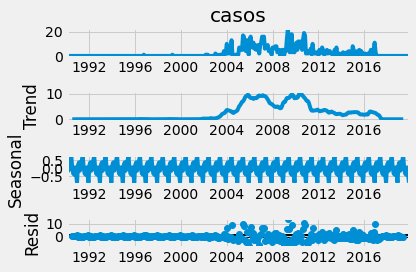

In [54]:
decomposition = sm.tsa.seasonal_decompose(x=ts['casos'], model='additive', period=12)
_ = decomposition.plot()

<AxesSubplot:xlabel='fecha'>

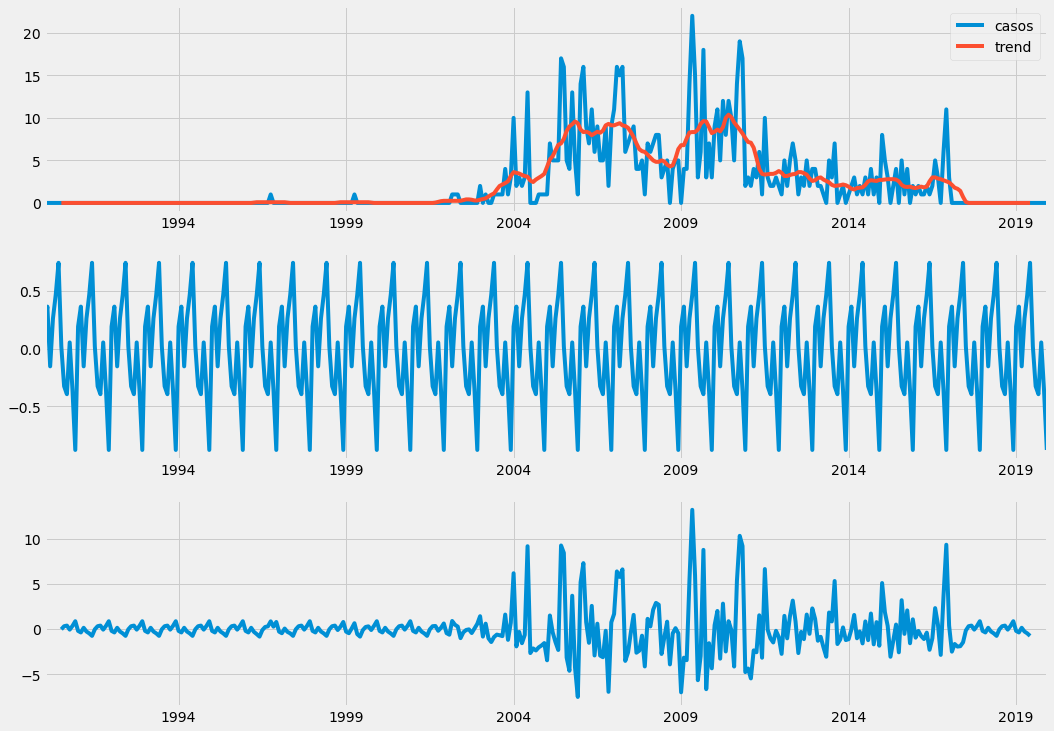

In [55]:
i=4
plt.figure(figsize=(4*i,3*i))
plt.subplot(3,1,1)
plt.gca().xaxis.label.set_visible(False)
decomposition.observed.plot()
decomposition.trend.plot()
plt.legend()
plt.subplot(3,1,2)
plt.gca().xaxis.label.set_visible(False)
decomposition.seasonal.plot()
plt.subplot(3,1,3)
plt.gca().xaxis.label.set_visible(False)
decomposition.resid.plot()

<AxesSubplot:xlabel='fecha'>

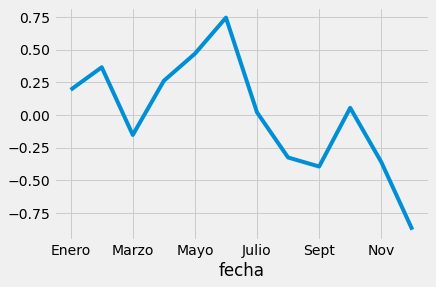

In [37]:
months = ['','Enero','Feb','Marzo','Abr','Mayo','Jun','Julio','Ago','Sept','Oct','Nov','Dic']
patronEstacional = decomposition.seasonal[:'1990-12-01'].rename(
lambda x: months[x.month])
patronEstacional.plot()

### Exploración de hiperparámetros

In [38]:
def findOptimalSarimaxParameters(P_range, D_range, Q_range,order):
    m = 12
    seasonal_pdq_values = list(itertools.product(P_range, D_range, Q_range))
    seasonal_pdq_values = [(x[0], x[1], x[2], m) for x in list(itertools.product(P_range, D_range, Q_range))]
    orders = []
    min_aic = 10**5
    optimalParams = None
    for seasonal_order in seasonal_pdq_values:
        model = SARIMAX(timeSeries, order=order, seasonal_order=seasonal_order,
                enforce_stationarity=False, enforce_invertibility=False)
        results = model.fit()
        aic = results.aic
        if aic < min_aic:
            min_aic = aic
            optimalParams = seasonal_order
            print(seasonal_order,'\t',aic)
        orders.append((seasonal_order,aic))
        if seasonal_order[2] == 0:
            print('\t\t',seasonal_order)
    return orders

In [39]:
p_r = range(0,6)
d_r = range(1,2)
q_r = range(0,4)
orders = findOptimalSarimaxParameters(p_r, d_r, q_r, order)
#orders

(0, 1, 0, 12) 	 1862.0572794101145
		 (0, 1, 0, 12)
(0, 1, 1, 12) 	 1652.6478682695247
(0, 1, 2, 12) 	 1606.412915781285
(0, 1, 3, 12) 	 1561.0418856889673
		 (1, 1, 0, 12)
(1, 1, 3, 12) 	 1558.8830452947318
		 (2, 1, 0, 12)
(2, 1, 3, 12) 	 1558.4934807105042
		 (3, 1, 0, 12)
(4, 1, 0, 12) 	 1539.3180337081624
		 (4, 1, 0, 12)
(4, 1, 1, 12) 	 1528.399954850649
(4, 1, 2, 12) 	 1521.3678126776636
(4, 1, 3, 12) 	 1519.3273181301158
(5, 1, 0, 12) 	 1488.6235347264274
		 (5, 1, 0, 12)
(5, 1, 1, 12) 	 1475.272900090887
(5, 1, 2, 12) 	 1469.037365721701
(5, 1, 3, 12) 	 1467.651463605801


In [40]:
for order,aic in orders:
    if (aic < 1500):
        print(order,aic)

(5, 1, 0, 12) 1488.6235347264274
(5, 1, 1, 12) 1475.272900090887
(5, 1, 2, 12) 1469.037365721701
(5, 1, 3, 12) 1467.651463605801


### Entrenamiento del modelo SARIMAX con parámetros óptimos

In [41]:
P,D,Q,m = (5, 1, 3, 12)
model = SARIMAX(timeSeries, order=(p,d,q), seasonal_order=(P,D,Q,m),
            enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              casos   No. Observations:                  360
Model:             SARIMAX(3, 1, 3)x(5, 1, 3, 12)   Log Likelihood                -718.826
Date:                            Wed, 02 Dec 2020   AIC                           1467.651
Time:                                    08:06:30   BIC                           1522.386
Sample:                                01-31-1990   HQIC                          1489.596
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7024      0.053    -13.198      0.000      -0.807      -0.598
ar.L2         -0.6954      0.055    -12.696      0.000      -0.803      -0.588
ar.L3          0.2011      0.054      3.718      0.000       0.095       0.307
ma.L1          0.1830      1.352      0.135      0.892      -2.468       2.834
ma.L2          0.0952      1.429      0.067      0.947      -2.705       2.896
ma.L3         -0.8639      2.230     -0.387      0.698      -5.234       3.506
ar.S.L12      -0.8033      0.851     -0.944      0.345      -2.471       0.864
ar.S.L24      -0.3401      0.646     -0.527      0.598      -1.606       0.926
ar.S.L36      -0.0536      0.111     -0.481      0.631      -0.272       0.165
ar.S.L48      -0.1327      0.106     -1.253      0.210      -0.340       0.075
ar.S.L60    1.552e-05      0.123      0.000      1.000      -0.242       0.242
ma.S.L12      -0.1575     82.488     -0.002      0.998    -161.831     161.516
ma.S.L24      -0.5188     69.644     -0.007      0.994    -137.019     135.982
ma.S.L36      -0.3238     26.812     -0.012      0.990     -52.874      52.227
sigma2         8.2233    685.767      0.012      0.990   -1335.855    1352.301
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               206.53
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               4.56   Skew:                             0.89
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
patronEstacional

fecha
Enero    0.192529
Feb      0.364943
Marzo   -0.152299
Abr      0.261494
Mayo     0.468391
Jun      0.744253
Julio    0.020115
Ago     -0.324713
Sept    -0.393678
Oct      0.054598
Nov     -0.359195
Dic     -0.876437
Name: seasonal, dtype: float64

<AxesSubplot:>

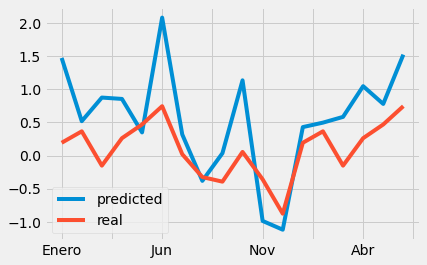

In [43]:
prediction = results.get_forecast(steps=12+6,dynamic=True)
a = prediction.predicted_mean['2018-01':]
a = a.rename(index=lambda x:months[int(str(x).split('-')[1])])
a = a.rename('predicted')
df = pd.DataFrame(a)
b = patronEstacional
#b = b.rename(index=lambda x:str(x).split('-')[1])
b = b.rename('real')
df['real'] = b
df.plot()

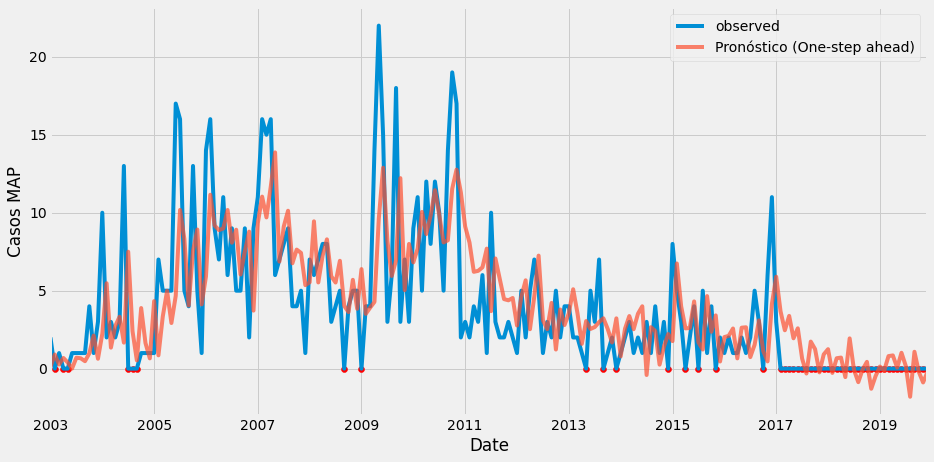

In [44]:
fechaInicio = '2003-01-01'
pred = results.get_prediction(start=pd.to_datetime(fechaInicio), dynamic=False)
casos_predecidos = pred.predicted_mean
casos_reales = timeSeries[fechaInicio:]['casos']
pred_ci = pred.conf_int()
ax = casos_reales.plot(label='observed')
points = casos_reales[casos_reales == 0]
plt.scatter(points.index, points.values, color='red')
pred.predicted_mean.plot(ax=ax, label='Pronóstico (One-step ahead)', alpha=.7, figsize=(14, 7))
#ax.fill_between(pred_ci.index,
#                pred_ci.iloc[:, 0],
#                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Casos MAP')
plt.legend()

In [45]:
mse = ((casos_predecidos - casos_reales) ** 2).mean()
print('MSE (Mean Squared Error)  {}'.format(round(mse, 2)))
print('Root MSE: {}'.format(round(np.sqrt(mse), 2)))

MSE (Mean Squared Error)  12.36
Root MSE: 3.52


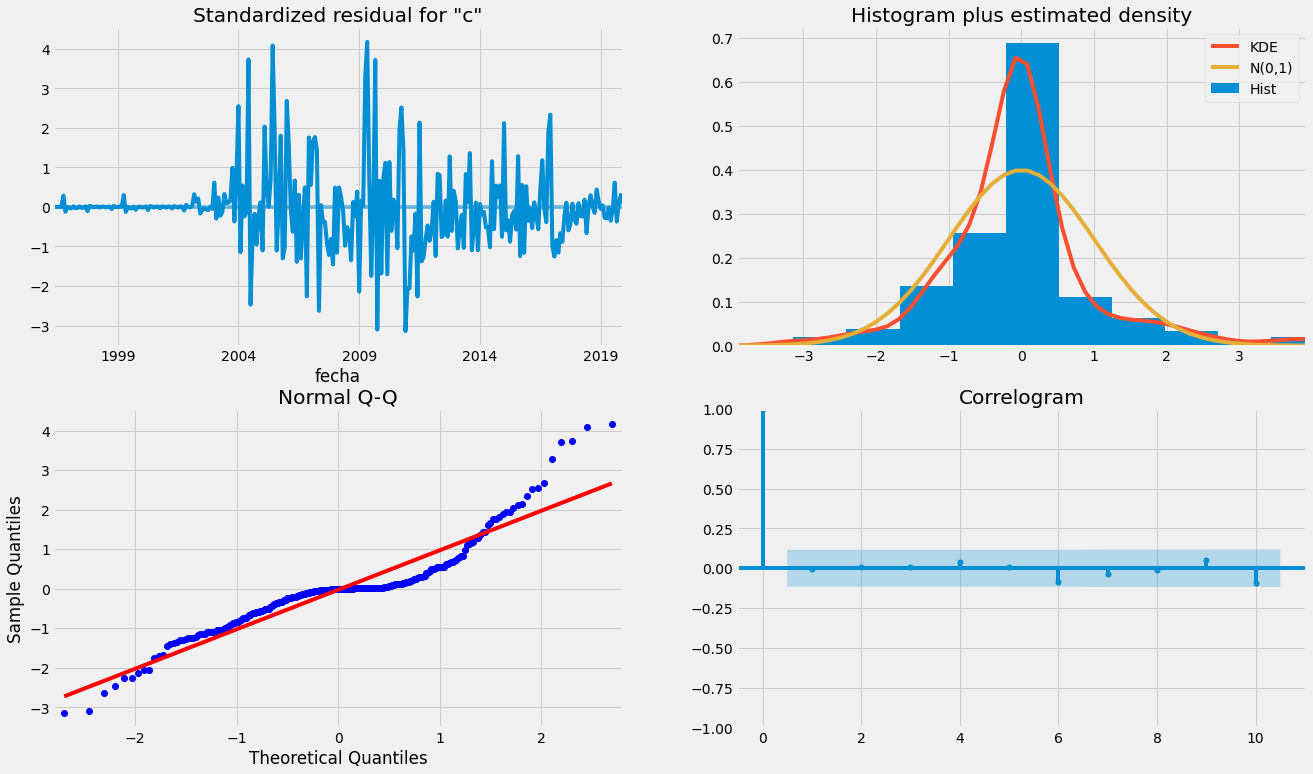

In [46]:
_ = results.plot_diagnostics(figsize=(20,12))

         residual
count  360.000000
mean    -0.066354
std      2.651799
min     -9.308519
25%     -0.687168
50%      0.000000
75%      0.130809
max     12.410592


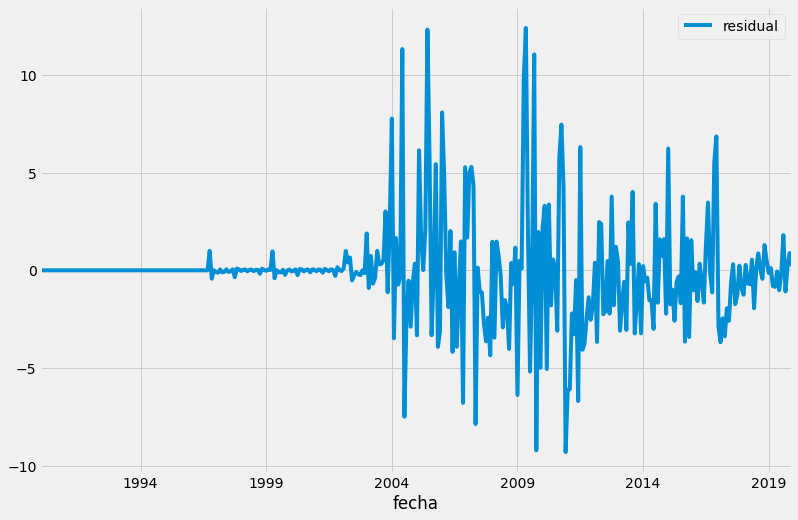

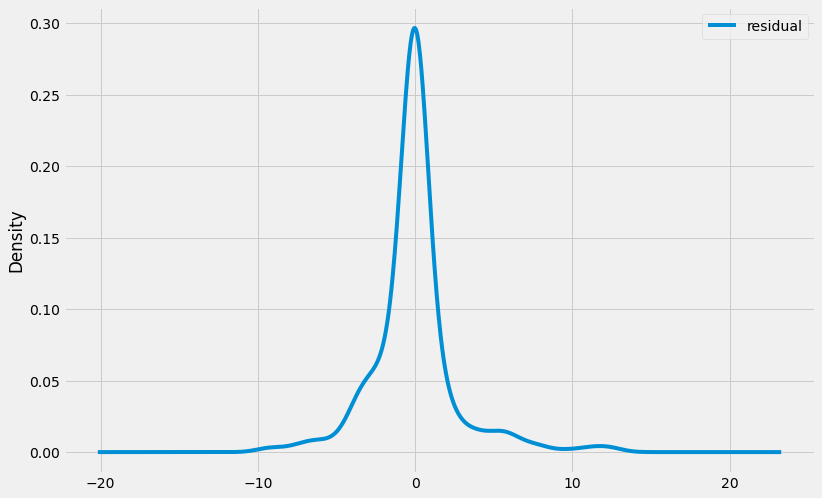

In [47]:
residuals = pd.DataFrame(results.resid)
residuals.rename(columns=lambda x:"residual" ,inplace=True)
residuals.plot(figsize=(12,8))
residuals.plot(kind='kde',figsize=(12,8))
print(residuals.describe())